# Demonstration of Automatic Data Processing *without MOSEK*

## Clean data set example

7/7/21

This notebook demonstrates the newly added support for open-source solvers. This feature is currently for testing and R&D purposes only, and the authors make no claims as to the stability or speed of the open-source solvers.

### Notebook setup and library imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# PVInsight Code Imports
from solardatatools import DataHandler
from solardatatools.dataio import get_pvdaq_data

### Load data table from external source

For today's example, we're loading data from NREL's PVDAQ API, which is a publically available PV generatation data set. 

In [2]:
data_frame = get_pvdaq_data(sysid=34, year=range(2011, 2015), api_key='DEMO_KEY')[0]

In [3]:
data_frame.head()

,SiteID,ac_current,ac_power,ac_voltage,ambient_temp,dc_current,dc_power,dc_voltage,inverter_error_code,inverter_temp,module_temp,poa_irradiance,power_factor,relative_humidity,wind_direction,wind_speed
2011-01-01 00:00:00,34.0,0.0,-200.0,284.0,-3.353332,0.0,-200.0,16.0,0.0,37.0,-7.105555,0.0,0.0,53.513,315.270,0.483250
2011-01-01 00:15:00,34.0,0.0,-300.0,284.0,-3.381110,0.0,-200.0,16.0,0.0,36.0,-6.944444,0.0,0.0,53.581,308.835,0.698724
2011-01-01 00:30:00,34.0,0.0,-300.0,284.0,-3.257777,0.0,-200.0,16.0,0.0,36.0,-6.344444,0.0,0.0,53.413,272.678,0.218156
2011-01-01 00:45:00,34.0,0.0,-200.0,283.0,-3.296666,0.0,0.0,15.0,0.0,36.0,-6.655555,0.0,0.0,52.406,55.913,0.159146
2011-01-01 01:00:00,34.0,0.0,-300.0,284.0,-3.426110,0.0,-200.0,14.0,0.0,35.0,-7.405555,0.0,0.0,53.588,152.145,0.240508


### Running the `DataHandler` processing pipeline

In [4]:
dh = DataHandler(data_frame)

In [5]:
dh.run_pipeline(power_col='ac_power', solver='SCS')

/Users/bennetmeyers/miniconda3/envs/pvi-dev/lib/python3.7/site-packages/cvxpy/problems/problem.py:1246: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "
/Users/bennetmeyers/miniconda3/envs/pvi-dev/lib/python3.7/site-packages/cvxpy/problems/problem.py:1246: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "
/Users/bennetmeyers/miniconda3/envs/pvi-dev/lib/python3.7/site-packages/cvxpy/problems/problem.py:1246: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "


total time: 625.45 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              12.21s
Cleaning                   566.11s
Filtering/Summarizing      47.14s
    Data quality           4.59s
    Clear day detect       7.32s
    Clipping detect        17.84s
    Capacity change detect 17.39s



### Top-level reporting

First we view a quick summary of the data set. 

In [6]:
dh.report()

Length:                4.00 years
Capacity estimate:     107.10 kW
Data sampling:         15 minute
Data quality score:    95.6%
Data clearness score:  55.6%
Inverter clipping:     False
Time shifts corrected: False
Time zone correction:  None


We use heat maps to view the entire data set at once. This provides a much clearer picture of system performance and data set quality than trying to view the time series signal over multiple years.

The "raw" matrix is the initial embedding of the data table after infering the correct shape (number of data points per day by the number of full days) and standardizing the time axis. The white spaces are missing data.

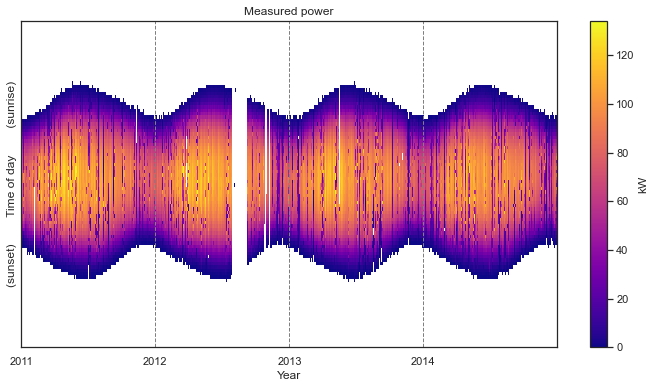

In [7]:
dh.plot_heatmap(matrix='raw');

The "filled" matrix is a formal matrix $M\in\mathbf{R}^{m\times n}$. All entries are real-valued. Night time values and missing days are filled with zeros. Gap within days are filled with linear interpolation.

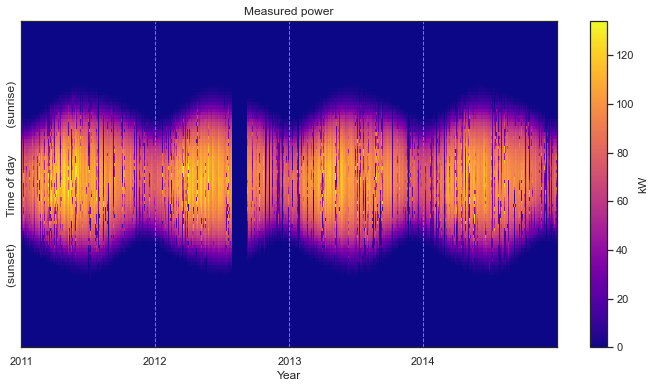

In [8]:
dh.plot_heatmap(matrix='filled', scale_to_kw=True);

### Access to data

Data is available in a number of formats. The first is the original tabular data used at class instantiation.

In [9]:
type(dh.data_frame)

pandas.core.frame.DataFrame

In [10]:
dh.data_frame.columns

Index(['SiteID', 'ac_current', 'ac_power', 'ac_voltage', 'ambient_temp',
       'dc_current', 'dc_power', 'dc_voltage', 'inverter_error_code',
       'inverter_temp', 'module_temp', 'poa_irradiance', 'power_factor',
       'relative_humidity', 'wind_direction', 'wind_speed', 'seq_index'],
      dtype='object')

In [11]:
dh.data_frame['ac_power'].max()

134000.0

In [12]:
dh.data_frame['ac_power'].min()

-1300.0

The second is the "raw" data matrix. This is a 2D `numpy.array` object created from the tabular data. Some entries may be missing if there was not a measurement reported for that timestamp in the data table.

In [13]:
dh.raw_data_matrix.shape

(96, 1461)

In [14]:
np.max(dh.raw_data_matrix)

nan

In [15]:
np.min(dh.raw_data_matrix)

nan

Finally, we have the "filled" data matrix. This 2D `numpy.array` has a real float value in every entry.

In [16]:
dh.filled_data_matrix.shape

(96, 1461)

In [17]:
np.max(dh.filled_data_matrix)

134000.0

In [18]:
np.min(dh.filled_data_matrix)

0.0

### Daywise filtering and selection

After running the pipeline, the class has an attribute which holds a number of boolian indices, each of a length equal to the number of days in the data set. The available flags to filter on are shown below.

In [19]:
dh.daily_flags.__dict__.keys()

dict_keys(['density', 'linearity', 'no_errors', 'clear', 'cloudy', 'inverter_clipped', 'capacity_cluster'])

In [20]:
dh.daily_flags.no_errors

array([ True,  True,  True, ...,  True,  True,  True])

### Seasonal analysis using circular statistics

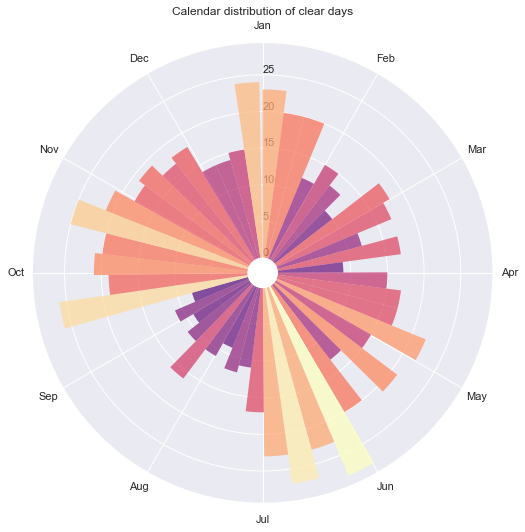

In [21]:
dh.plot_circ_dist(flag='clear');

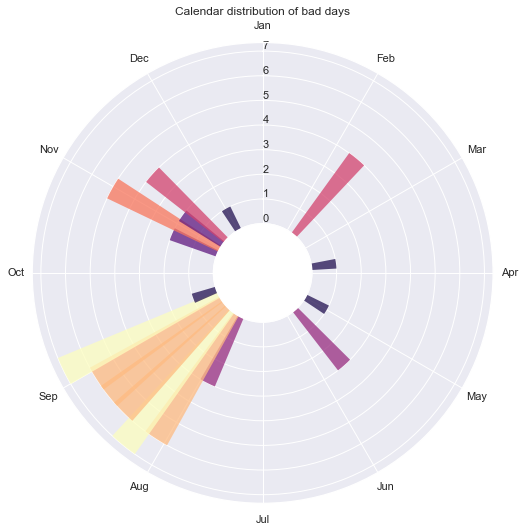

In [22]:
dh.plot_circ_dist(flag='bad');

### Views into the behavior of the algorithms

_Data quality flagging_

#### Clear Days

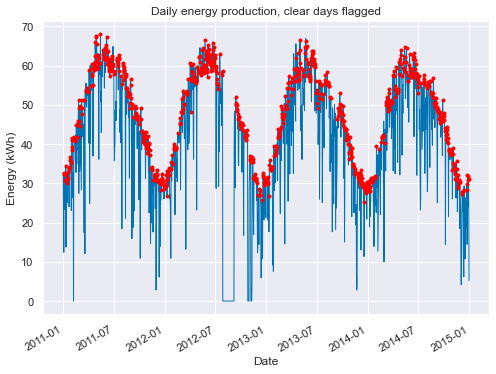

In [23]:
dh.plot_daily_energy(flag='clear');

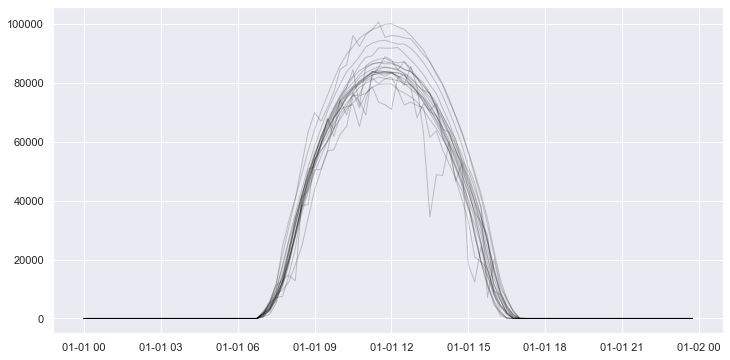

In [24]:
bix = dh.daily_flags.clear
dh.plot_daily_signals(boolean_index=bix, start_day=0, num_days=20, ravel=False, color='black', alpha=0.2);

#### Missing/corrupted data

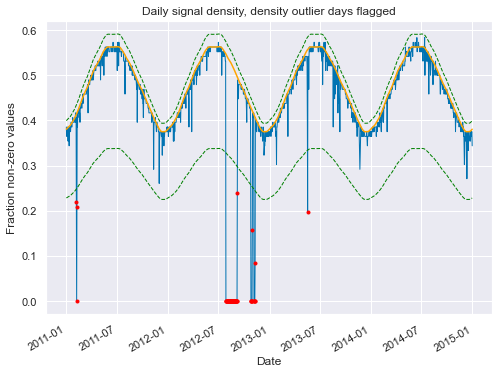

In [25]:
dh.plot_density_signal(show_fit=True, flag='density');

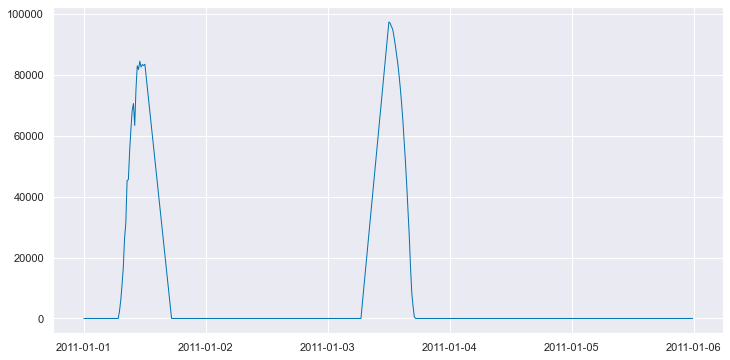

In [26]:
# Select days that failed the density test
bix = ~dh.daily_flags.density
dh.plot_daily_signals(boolean_index=bix, start_day=0, num_days=5, ravel=True);

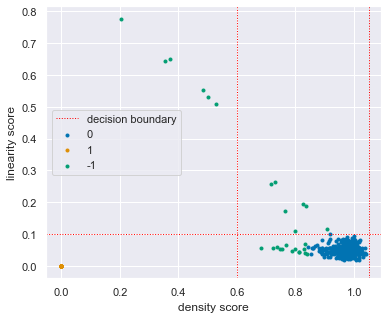

In [27]:
dh.plot_data_quality_scatter();

### Capacity change analysis

This analysis checks for abrupt step changes in the apparent capacity of the system.

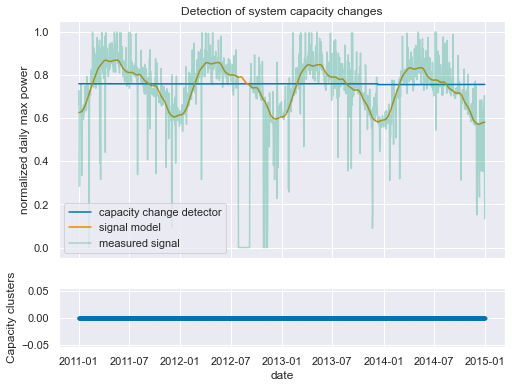

In [28]:
dh.plot_capacity_change_analysis();

### Clipping analysis

These plots show how clipped days are detected (none in this data set).

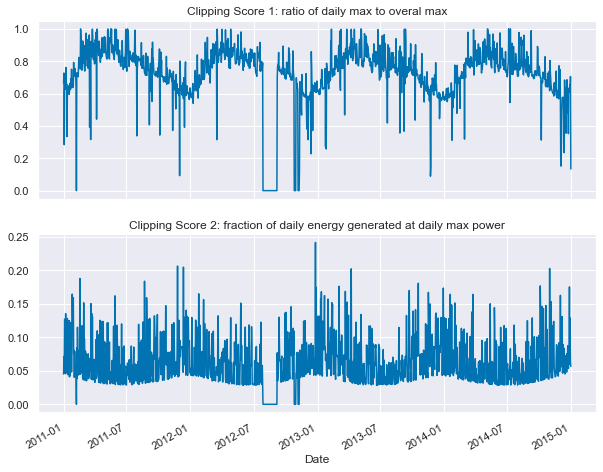

In [29]:
dh.plot_clipping();

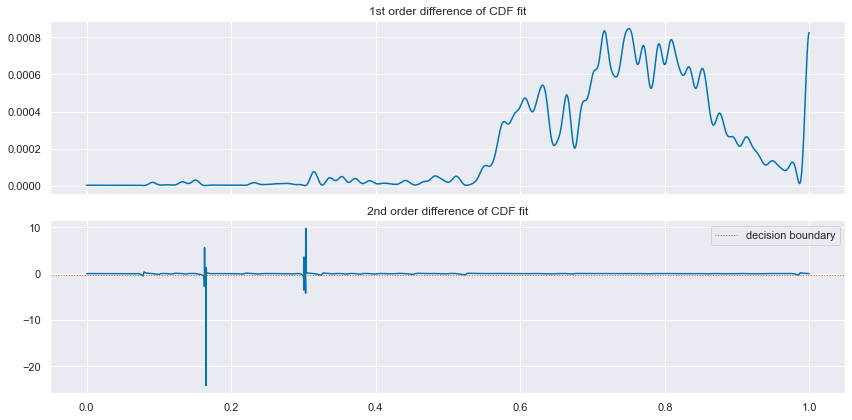

In [30]:
dh.plot_cdf_analysis();